In [183]:
import numpy as np
import pandas as pd
import sklearn as sk

I begin by importing the various metrics that would be used to build the model. The vast majority of data cleaning was done on excel for the sake of simplicity. The data was collecting from StatHead's Fbref. For each group of metrics, a total of 10 files, each with 200 observations except for the last one, were merged to produce the final file. I now import them below.

In [184]:
xg = pd.read_csv("xg.csv", encoding='ISO-8859-1')
passes = pd.read_csv("passes.csv", encoding='ISO-8859-1')
defstats = pd.read_csv("def.csv", encoding='ISO-8859-1')

I will first check the shape to ensure that they have the same number of observations.

In [227]:
xg.shape

(1810, 39)

In [208]:
passes.shape

(1810, 41)

In [225]:
defstats.shape

(1810, 24)

For the sake of reference and copy-pasting, I will now print out the columns

In [209]:
xg.columns

Index(['Rk', 'Player', 'xG/90', 'Season', 'Age', 'Nation', 'Team', 'Comp',
       'MP', 'Min', '90s', 'Starts', 'Subs', 'unSub', 'Gls', 'Ast', 'G+A',
       'G-PK', 'PK', 'PKatt', 'PKm', 'xG/90.1', 'npxG', 'xAG', 'xG+xAG', 'xA',
       'npxG+xAG', 'G-xG', 'np:G-xG', 'A-xAG', 'npxG/Sh', 'Sh', 'G/Sh',
       'G/SoT', 'SoT', 'SoT%', 'Dist', 'FK', 'Pos'],
      dtype='object')

In [210]:
passes.columns

Index(['Rk', 'Player', 'Cmp/90', 'Season', 'Age', 'Nation', 'Team', 'Comp',
       'MP', 'Min', '90s', 'Starts', 'Subs', 'unSub', 'Gls', 'Ast', 'G+A',
       'G-PK', 'PK', 'PKatt', 'PKm', 'TotalCmp/90', 'TotalAtt', 'TotalCmp%',
       'TotalKP', 'passesToFinalThird', 'PPA', 'CrsPA', 'PrgP', 'TotDist',
       'PrgDist', 'ShortCmp', 'ShortAtt', 'ShortCmp%', 'MedCmp', 'MedAtt',
       'MedCmp%', 'LongCmp', 'LongAtt', 'LongCmp%', 'Pos'],
      dtype='object')

In [212]:
defstats.columns

Index(['Rk', 'Player', 'Season', 'Age', 'Nation', 'Team', 'Comp', 'Tkl/90',
       'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Challenges Tkl',
       'ChallengesAtt', 'Challenges Tkl%', 'Challenges Lost', 'Blocks',
       'Sh Blocks', 'Pass Blocks', 'Int', 'Tkl+Int', 'Clr', 'Err', 'Pos'],
      dtype='object')

Below, I merge the dataframes through a two step process. 

In [213]:
passes_clean = passes.drop(columns=["Gls", "Ast", "G+A", "G-PK", "PK", "PKatt", "PKm"])

df = pd.merge(
    xg,
    passes_clean,
    on=["Player", "Season", "Team", "Comp", "Age", "Nation", "Pos"],
)

df = pd.merge(
    df,
    defstats,
    on=["Player", "Season", "Team", "Comp", "Age", "Nation", "Pos"],
)

df.columns

Index(['Rk_x', 'Player', 'xG/90', 'Season', 'Age', 'Nation', 'Team', 'Comp',
       'MP_x', 'Min_x', '90s_x', 'Starts_x', 'Subs_x', 'unSub_x', 'Gls', 'Ast',
       'G+A', 'G-PK', 'PK', 'PKatt', 'PKm', 'xG/90.1', 'npxG', 'xAG', 'xG+xAG',
       'xA', 'npxG+xAG', 'G-xG', 'np:G-xG', 'A-xAG', 'npxG/Sh', 'Sh', 'G/Sh',
       'G/SoT', 'SoT', 'SoT%', 'Dist', 'FK', 'Pos', 'Rk_y', 'Cmp/90', 'MP_y',
       'Min_y', '90s_y', 'Starts_y', 'Subs_y', 'unSub_y', 'TotalCmp/90',
       'TotalAtt', 'TotalCmp%', 'TotalKP', 'passesToFinalThird', 'PPA',
       'CrsPA', 'PrgP', 'TotDist', 'PrgDist', 'ShortCmp', 'ShortAtt',
       'ShortCmp%', 'MedCmp', 'MedAtt', 'MedCmp%', 'LongCmp', 'LongAtt',
       'LongCmp%', 'Rk', 'Tkl/90', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd',
       'Challenges Tkl', 'ChallengesAtt', 'Challenges Tkl%', 'Challenges Lost',
       'Blocks', 'Sh Blocks', 'Pass Blocks', 'Int', 'Tkl+Int', 'Clr', 'Err'],
      dtype='object')

For this initial model, I will be using all the metrics at my disposal to produce the model. So, I define the feature set to include all metrics that I believe would be useful to compare players. However, one may notice that multiple variables are correlated, which will lead to multi-collinearity. Although this will not necessarily stop the model from producing reasonable output, it is in my best interest to remove certain variables so as to curb the bias that may occur from including correlated metrics. For this reason, I will remove the following statistics: 'Challenges Tkl%', 'xG+xAG', 'npxG+xAG'.

In [214]:
features = [
    "Gls", "Ast", "G+A",                # output
    "xG/90", "npxG", "xAG", 
    "Sh", "SoT", "Dist",   # xG stuff
    "Cmp/90", "TotalCmp/90", "TotalCmp%", "TotalKP", 
    "passesToFinalThird", "PPA", "CrsPA", "PrgP",  # passing
    'Tkl/90', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Challenges Tkl', #defensive stats
    'ChallengesAtt', 'Challenges Lost', 'Blocks',
    'Sh Blocks', 'Pass Blocks', 'Int', 'Tkl+Int', 'Clr', 'Err'
]
df = df.fillna(0)
X = df[features]

In [215]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [218]:
model = NearestNeighbors(metric="cosine", algorithm="brute")
model.fit(X_scaled)

NearestNeighbors(algorithm='brute', metric='cosine')

In [222]:
def find_similar(player_name, n=5):
    idx = df.index[df["Player"] == player_name][0]
    player_vec = X_scaled[idx].reshape(1, -1)
    distances, indices = model.kneighbors(player_vec, n_neighbors=n+1)

    results = df.iloc[indices[0][1:]][["Player", "Team", "Season", "Pos", "Gls", "Ast", "G+A"]]
    results["SimilarityScore"] = 1 - distances[0][1:]
    return results

# Example
print(find_similar("Pedro Porro", n=5))

                      Player       Team     Season Pos  Gls  Ast  G+A  \
1419  Maximilian Mittelstädt  Stuttgart  2024-2025  DF  0.0  0.3  0.3   
968   Trent Alexander-Arnold  Liverpool  2024-2025  DF  0.1  0.2  0.3   
1583        Antonee Robinson     Fulham  2024-2025  DF  0.0  0.3  0.3   
1125         Luca Pellegrini      Lazio  2024-2025  DF  0.0  0.3  0.3   
1684              Diego Rico     Getafe  2024-2025  DF  0.0  0.1  0.1   

      SimilarityScore  
1419         0.906838  
968          0.856577  
1583         0.805200  
1125         0.802930  
1684         0.766689  


C:\Users\tejas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


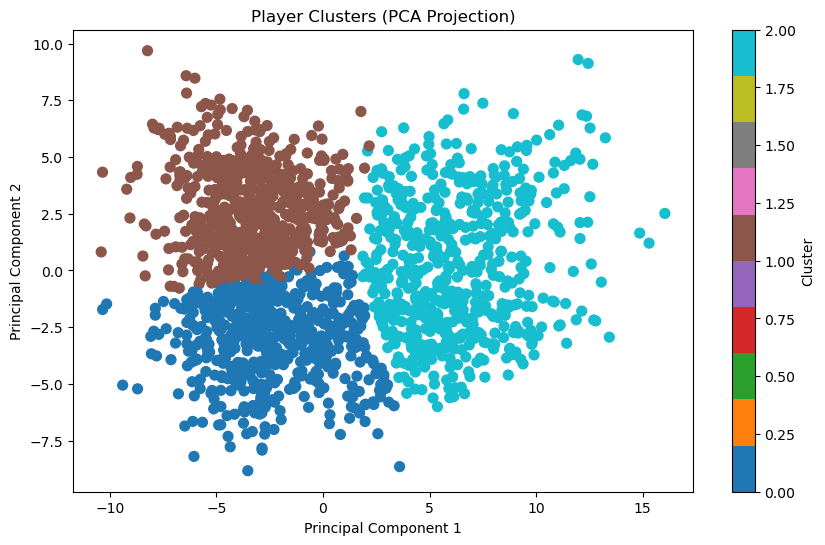

In [234]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

X = df.select_dtypes(include='number') 

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df['Cluster'] = clusters
df['PC1'] = X_pca[:,0]
df['PC2'] = X_pca[:,1]

# Plot
plt.figure(figsize=(10,6))
plt.scatter(df['PC1'], df['PC2'], c=df['Cluster'], cmap='tab10', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Player Clusters (PCA Projection)')
plt.colorbar(label='Cluster')
plt.show()